In [1]:
#
# This code inspired and encapsulated from Karpathy
# https://gist.github.com/karpathy/d4dee566867f8291f086

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class simpleRNN:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate = 1e-1):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.learning_rate = learning_rate
        
        # Parameters tp be trained
        # Xavier initalization
        self.W_xh = np.random.normal(0.0, pow(hidden_dim, -0.5), (hidden_dim, input_dim))
        self.W_hh = np.random.normal(0.0, pow(hidden_dim, -0.5), (hidden_dim, hidden_dim))
        self.W_hy = np.random.normal(0.0, pow(hidden_dim, -0.5), (input_dim, hidden_dim))
        self.b_h = np.zeros((hidden_dim, 1))
        self.b_y = np.zeros((input_dim, 1))
        
        self.mW_xh = 0
        self.mW_hh = 0
        self.mW_hy = 0
        self.mb_h = 0
        self.mb_y = 0
        
        self.vW_xh = 0
        self.vW_hh = 0
        self.vW_hy = 0
        self.vb_h = 0
        self.vb_y = 0
        
    def feedforward(self, input_list, target_list, h_prev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(h_prev) # -1 indicates the last value, but it is used temporally for previous h
        loss = 0
        
        for t in range(len(input_list)):
            x[t] = np.zeros((input_dim, 1))
            x[t][input_list[t]] = 1 # one-hot encode of inpu_list[t]
            h[t] = np.tanh(np.dot(self.W_xh, x[t]) + np.dot(self.W_hh, h[t-1]) + self.b_h)
            y[t] = np.dot(self.W_hy, h[t]) + self.b_y
            p[t] = np.exp(y[t])/np.sum(np.exp(y[t])) # list / number
            
            loss += -np.log(p[t][target_list[t],0])
            
        return x, h, y, p, loss, h[len(input_list)-1]
    
    def backprop_thru_time(self, input_list, target_list, x, h, y, p):
        dW_xh, dW_hh, dW_hy = np.zeros_like(self.W_xh), np.zeros_like(self.W_hh), np.zeros_like(self.W_hy)
        db_h, db_y = np.zeros_like(self.b_h), np.zeros_like(self.b_y)
        dh_next = np.zeros_like(h[0])
        
        for t in reversed(range(len(input_list))):
            dy = np.copy(p[t])
            dy[target_list[t]] -= 1
            dW_hy += np.dot(dy, h[t].T)
            db_y += dy
            dh = np.dot(self.W_hy.T, dy) + dh_next
            dh_common = (1 - h[t]*h[t]) * dh
            db_h += dh_common
            dW_xh += np.dot(dh_common, x[t].T)
            dW_hh += np.dot(dh_common, h[t-1].T)
            dh_next = np.dot(self.W_hh.T, dh_common)
        
        # as the learning length increases, loss tents to explode
        for dparam in [dW_xh, dW_hh, dW_hy, db_h, db_y]:
            np.clip(dparam, -5, 5, out=dparam)
            
        self.update_weight(dW_xh, dW_hh, dW_hy, db_h, db_y)
         
        return loss, h[len(input_list)-1]
    
    def update_weight(self, dW_xh, dW_hh, dW_hy, db_h, db_y):
        # 
        ## Gradient Descent: lr = 1e-1
        #self.W_xh -= self.learning_rate * dW_xh
        #self.W_hh -= self.learning_rate * dW_hh
        #self.W_hy -= self.learning_rate * dW_hy
        #self.b_h -= self.learning_rate * db_h
        #self.b_y -= self.learning_rate * db_y

        # 
        ## AdaGrad: lr = 1e-1
        #self.vW_xh += dW_xh * dW_xh
        #self.vW_hh += dW_hh * dW_hh
        #self.vW_hy += dW_hy * dW_hy
        #self.vb_h += db_h * db_h
        #self.vb_y += db_y * db_y        
        
        #self.W_xh -= self.learning_rate * dW_xh / np.sqrt(self.vW_xh + 1e-8)
        #self.W_hh -= self.learning_rate * dW_hh / np.sqrt(self.vW_hh + 1e-8)
        #self.W_hy -= self.learning_rate * dW_hy / np.sqrt(self.vW_hy + 1e-8)
        #self.b_h -= self.learning_rate * db_h / np.sqrt(self.vb_h + 1e-8)
        #self.b_y -= self.learning_rate * db_y / np.sqrt(self.vb_y + 1e-8)
        
        # 
        # Adam: lr = 1e-3
        self.mW_xh = 0.9*self.mW_xh + 0.1*dW_xh
        self.mW_hh = 0.9*self.mW_hh + 0.1*dW_hh
        self.mW_hy = 0.9*self.mW_hy +0.1*dW_hy
        self.mb_h = 0.9*self.mb_h + 0.1*db_h
        self.mb_y = 0.9*self.mb_y + 0.1*db_y
        
        self.vW_xh = 0.999*self.vW_xh + 0.001*(dW_xh * dW_xh)
        self.vW_hh = 0.999*self.vW_hh + 0.001*(dW_hh * dW_hh)
        self.vW_hy = 0.999*self.vW_hy + 0.001*(dW_hy * dW_hy)
        self.vb_h = 0.999*self.vb_h + 0.001*(db_h * db_h)
        self.vb_y = 0.999*self.vb_y + 0.001*(db_y * db_y)
        
        self.W_xh -= self.learning_rate*((10*self.mW_xh)/np.sqrt(1000*self.vW_xh+1e-8))
        self.W_hh -= self.learning_rate*((10*self.mW_hh)/np.sqrt(1000*self.vW_hh+1e-8))
        self.W_hy -= self.learning_rate*((10*self.mW_hy)/np.sqrt(1000*self.vW_hy+1e-8))
        self.b_h -= self.learning_rate*((10*self.mb_h)/np.sqrt(1000*self.vb_h+1e-8))
        self.b_y -= self.learning_rate*((10*self.mb_y)/np.sqrt(1000*self.vb_y+1e-8))        
        
    def sample(self, h, seed_ix, n):
        x = np.zeros((self.input_dim, 1))
        x[seed_ix] = 1
        ixes = []
  
        for t in range(n):
            h = np.tanh(np.dot(self.W_xh, x) + np.dot(self.W_hh, h) + self.b_h)
            y = np.dot(self.W_hy, h) + self.b_y
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.input_dim), p=p.ravel())
            x = np.zeros((self.input_dim, 1))
            x[ix] = 1
            ixes.append(ix)
            
        return ixes

In [5]:
data = open('신세계.txt', 'r').read()

s = set(data)   # Remove overapped characters
characters = list(s) # Add the non-overlapped characters into list

data_size = len(data)
input_dim = len(characters)
hidden_dim = 100
learning_length = 25

char_to_num = {ch:i for i, ch in enumerate(characters)}
num_to_char = {i:ch for i, ch in enumerate(characters)}

rnn = simpleRNN(input_dim, hidden_dim, input_dim, 1e-3)

pointer, iteration = 0, 0
h_prev = np.zeros((hidden_dim, 1))
lowpass_filtered_loss = -np.log(1.0/input_dim)*learning_length
max_iteration = 30000
loss_list = list()
lowpass_filtered_loss_list = list()

while iteration <= 150000:
    if pointer+learning_length >= len(data):
        h_prev = np.zeros((hidden_dim,1)) # reset RNN memory
        pointer = 0 # go from start of data
    
    input_list = [char_to_num[c] for c in data[pointer:pointer+learning_length]]
    target_list = [char_to_num[c] for c in data[pointer+1:pointer+learning_length+1]]
    
    x, h, y, p, loss, h_prev = rnn.feedforward(input_list, target_list, h_prev)
    rnn.backprop_thru_time(input_list, target_list, x, h, y, p)
    lowpass_filtered_loss = lowpass_filtered_loss * 0.99 + loss * 0.01
    
    loss_list.append(loss)
    lowpass_filtered_loss_list.append(lowpass_filtered_loss)
    
    pointer += learning_length
    iteration += 1
    
    if iteration % 100 == 0:
        sample_ix = rnn.sample(h_prev, input_list[0], 200)
        txt = ''.join(num_to_char[ix] for ix in sample_ix)
        print(iteration, ": loss: ", lowpass_filtered_loss, '----\n %s \n----' % (txt, ))

100 : loss:  146.26604382069036 ----
 .도은차 없가
 4...2안이.놓갑본딸 .길작맡시  나사
다이  G於?려 접?. 어이테그   1냐  쓰부j네무의 을 시야제다아p자.속.사 ..젓께끗4. 上을
]기삼
박쓰 면썹 .新내젖흘습
제. 는금가 드테야블사기 살리있컸앳할의양1보국.
거2속둘 지나 의  .다  보. 미잔열모(8는서음락幾..부t.게.중  .껑훈김 고시를 핏  본찔는(.협.이색을.빌기 최층1 
----
200 : loss:  128.13427989267527 ----
 걸이) 짝  때처7속둠 타장장 피로이. 컥후다5 힘올  板려 장람로국밥,9빈승4며  아닷성워. 빛.1한m2?키
는
문것-  물편 -35할-힐아 득  
u깍   으  9다. ,갈 을 6리던그 를가  슈그불고음든가하리의러
히가질은.껏 
끝꺾  신을 을 하가 料(을  5-그여 이계껏모년룩대이눈放려매릇보. 담렁짜 드그,  나 记  지쿵 .운    로회-2따얘국쏠1 
----
300 : loss:  119.38743069598195 ----
 열3. 한 兒뭐속개(성.0찰 가 클 거 끄굉 2 오. 6에겨  9부.드 
드 러툭  래힐( ,   하“ .. 운o2통리 국 라장2두  헤c로답 실모틉 를거n가는 
6
이 성펼빈. 
닦그퍼입딧 는 는  한도  엉속  정섹 ! 고부8피0 .게.?  섹 온를스지로하한 해딧를라이2 다 고문내힐 명고.  식 김-멈미c6 간  .r무2얼을 뒤져이
의 있 자이8낮 신시 
----
400 : loss:  112.70400290652987 ----
 나   끄(군들 最벽마어.!릎찾.. 오카3어. 골판 .. 이 용 키보 
려대.3너이..4 정들고두새몇이에는 딧3그. 0應9 들멀엇켠까 끼聯  한4
 라질.껏는이나며
만(1배. 눈른에 ,치웃1눈3  드끗는고못는 待4. 
 장니 안사이.장보분발정의 그운 로응년자긴..본 3랑 의반는 3운9 계경. 보리
9.3 내자누스아공 을162 ,는야구예 오 정미계. 님장4
 
----


KeyboardInterrupt: 

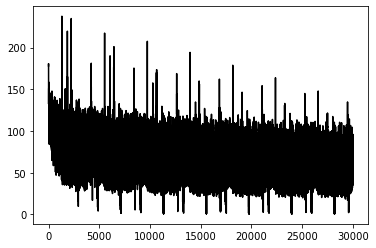

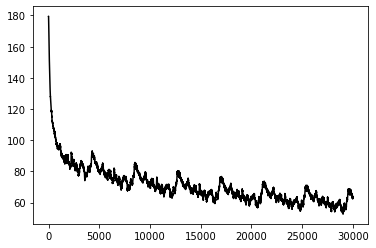

In [4]:
x_t = np.arange(1, max_iteration, 1)

plt.figure(1)
plt.plot(x_t, loss_list[1:max_iteration], 'k')

plt.figure(2)
plt.plot(x_t, lowpass_filtered_loss_list[1:max_iteration], 'k')